In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

import numpy as np
from scipy import interpolate

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|#########################| 1/1 [00:00<00:00, 7884.03it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12

OCEAN_VELOCITY_mon_mean_2000-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-07_ECCO_V4r4_native_llc0090.nc already exist

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

In [8]:
xfld = ecco_ds.UVEL.isel(k=0, time=0)
yfld = ecco_ds.VVEL.isel(k=0, time=0)

# Compute the zonal and meridional vector components of UVEL and VVEL
VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)

In [9]:
#get the speed values in 1 by 1 resolution
lon = np.linspace(-72,-67,6)
lat = np.linspace(34,39,6)
lon2d,lat2d = np.meshgrid(lon,lat)

speed = np.zeros((6, 6))
for i in range(0,6):
    for j in range(0,6):
        delta_lat = 1
        delta_lon = 1
        new_grid_min_lat = 34-1.5 + j
        new_grid_max_lat = 34+0.5 + j

        new_grid_min_lon = -72-1.5 + i
        new_grid_max_lon = -72+0.5 + i
        # interpolate to lat-lon
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        UVEL_latlon =\
            ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_E,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
    
        new_grid_lon_centers, new_grid_lat_centers,\
        new_grid_lon_edges, new_grid_lat_edges,\
        VVEL_latlon =\
            ecco.resample_to_latlon(ecco_ds.XC, \
                                    ecco_ds.YC, \
                                    VEL_N,\
                                    new_grid_min_lat, new_grid_max_lat, delta_lat,\
                                    new_grid_min_lon, new_grid_max_lon, delta_lat,\
                                    fill_value = np.NaN, \
                                    mapping_method = 'nearest_neighbor',
                                    radius_of_influence = 120000)
        speed_value = np.sqrt(UVEL_latlon[1,1]**2 + VVEL_latlon[1,1]**2)
        speed[i,j] = speed_value
        

In [10]:
#three different interpolation methods
cubic_interpolation = interpolate.interp2d(lon2d,lat2d,speed,kind='cubic')
linear_interpolation = interpolate.interp2d(lon2d,lat2d,speed,kind='linear')
quintic_interpolation = interpolate.interp2d(lon2d,lat2d,speed,kind='quintic')

In [12]:
#12 points
lon_12 = np.linspace(-72,-67,12)
lat_12 = np.linspace(34,39,12)
speed_12_linear = linear_interpolation(lon_12, lat_12)
speed_12_quintic = quintic_interpolation(lon_12, lat_12)
speed_12_cubic = cubic_interpolation(lon_12, lat_12)

In [13]:
#64 points
lon_64 = np.linspace(-72,-67,64)
lat_64 = np.linspace(34,39,64)
speed_64_linear = linear_interpolation(lon_64, lat_64)
speed_64_quintic = quintic_interpolation(lon_64, lat_64)
speed_64_cubic = cubic_interpolation(lon_64, lat_64)

In [14]:
#256 points
lon_256 = np.linspace(-72,-67,256)
lat_256 = np.linspace(34,39,256)
speed_256_linear = linear_interpolation(lon_256, lat_256)
speed_256_quintic = quintic_interpolation(lon_256, lat_256)
speed_256_cubic = cubic_interpolation(lon_256, lat_256)

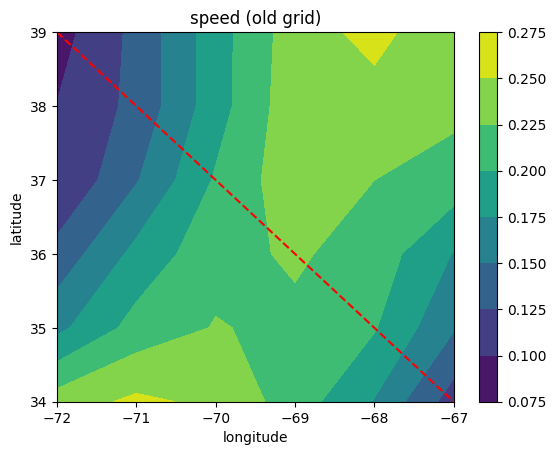

In [15]:
#plot speed in old grid (the red dashed line is a line segment)
plt.figure()
plt.contourf(lon, lat, speed)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('speed (old grid)')
plt.colorbar()

point1 = [-72, 39]
point2 = [-67, 34]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, linestyle="--", color = "red")

<Figure size 640x480 with 0 Axes>

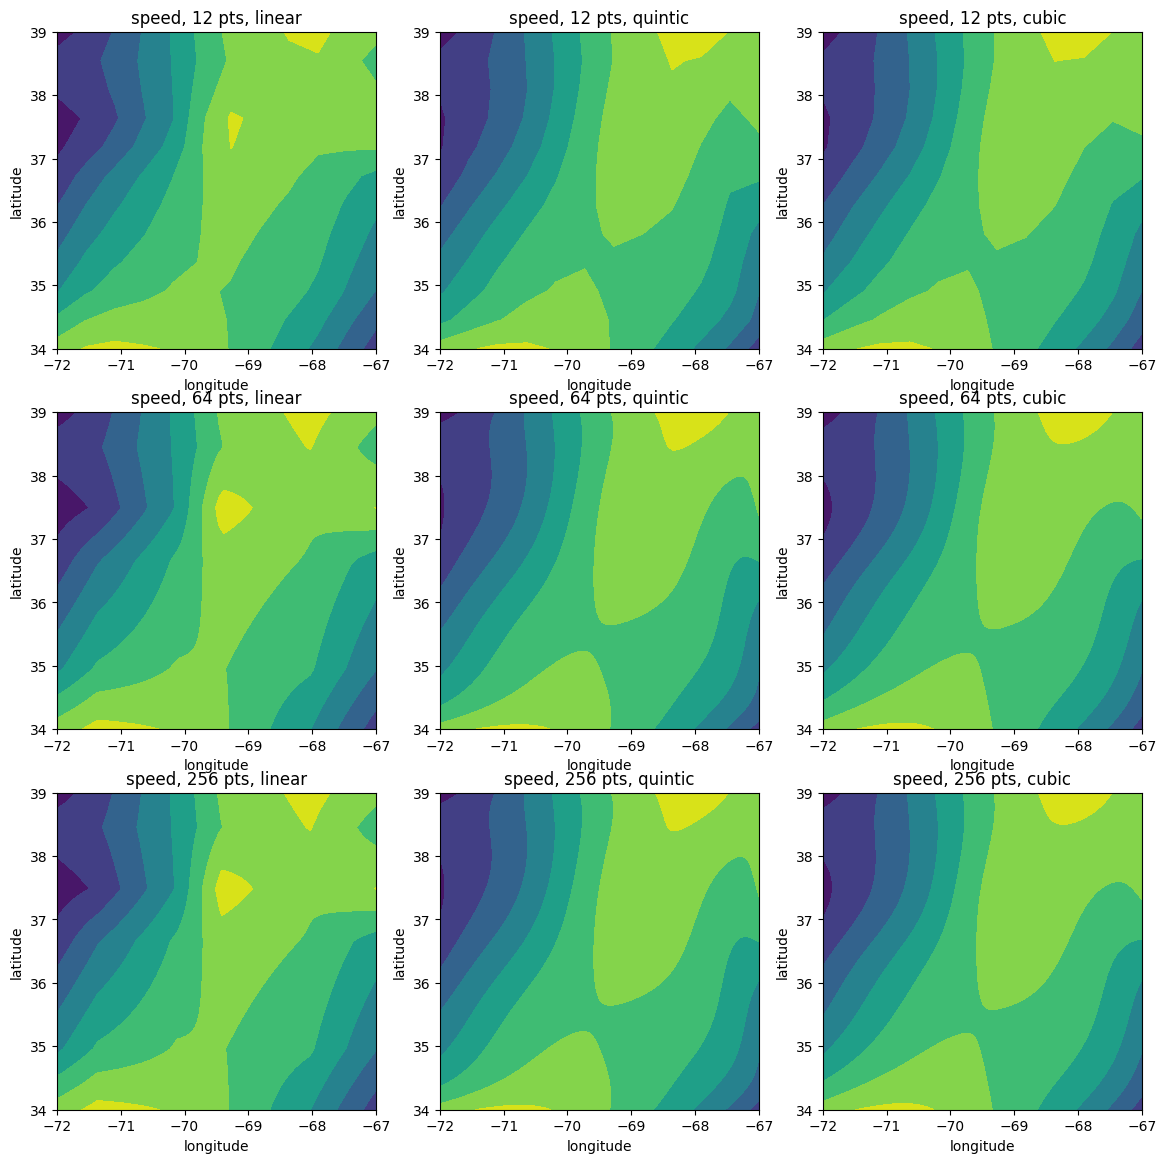

In [16]:
#plot speed profile derived using different interpolation methods and different number of points (new grid)
plt.figure()
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))

ax[0,0].contourf(lon_12, lat_12, speed_12_linear)
ax[0,0].set_title('speed, 12 pts, linear')
ax[0,0].set_xlabel('longitude')
ax[0,0].set_ylabel('latitude')

ax[0,1].contourf(lon_12, lat_12, speed_12_quintic)
ax[0,1].set_title('speed, 12 pts, quintic')
ax[0,1].set_xlabel('longitude')
ax[0,1].set_ylabel('latitude')

ax[0,2].contourf(lon_12, lat_12, speed_12_cubic)
ax[0,2].set_title('speed, 12 pts, cubic')
ax[0,2].set_xlabel('longitude')
ax[0,2].set_ylabel('latitude')

ax[1,0].contourf(lon_64, lat_64, speed_64_linear)
ax[1,0].set_title('speed, 64 pts, linear')
ax[1,0].set_xlabel('longitude')
ax[1,0].set_ylabel('latitude')

ax[1,1].contourf(lon_64, lat_64, speed_64_quintic)
ax[1,1].set_title('speed, 64 pts, quintic')
ax[1,1].set_xlabel('longitude')
ax[1,1].set_ylabel('latitude')

ax[1,2].contourf(lon_64, lat_64, speed_64_cubic)
ax[1,2].set_title('speed, 64 pts, cubic')
ax[1,2].set_xlabel('longitude')
ax[1,2].set_ylabel('latitude')

ax[2,0].contourf(lon_256, lat_256, speed_256_linear)
ax[2,0].set_title('speed, 256 pts, linear')
ax[2,0].set_xlabel('longitude')
ax[2,0].set_ylabel('latitude')

ax[2,1].contourf(lon_256, lat_256, speed_256_quintic)
ax[2,1].set_title('speed, 256 pts, quintic')
ax[2,1].set_xlabel('longitude')
ax[2,1].set_ylabel('latitude')

ax[2,2].contourf(lon_256, lat_256, speed_256_cubic)
ax[2,2].set_title('speed, 256 pts, cubic')
ax[2,2].set_xlabel('longitude')
ax[2,2].set_ylabel('latitude')

plt.savefig('myfile.png')

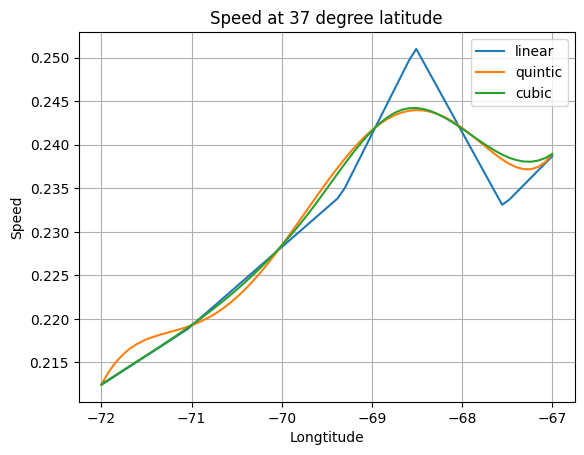

In [17]:
# compare three different methods at fixed latitude using 64 points for interpolation
fig, ax = plt.subplots()

plt.plot(lon_64, speed_64_linear[0:64, 38], label='linear')
plt.plot(lon_64, speed_64_quintic[0:64, 38], label='quintic')
plt.plot(lon_64, speed_64_cubic[0:64, 38], label='cubic')

plt.xlabel("Longtitude")
plt.ylabel("Speed")
plt.title("Speed at 37 degree latitude")
plt.grid()
plt.legend()

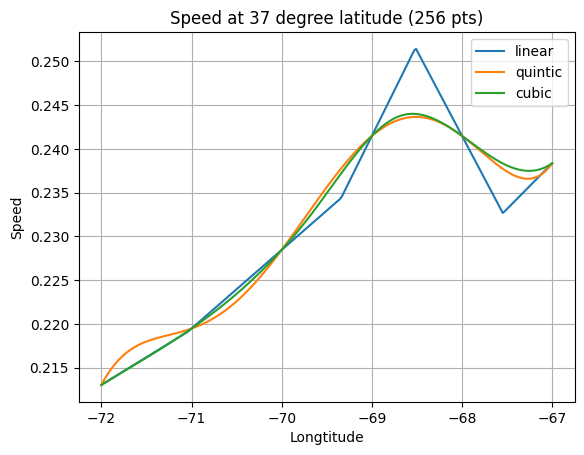

In [18]:
# compare three different methods at fixed latitude using 256 points for interpolation
fig, ax = plt.subplots()

plt.plot(lon_256, speed_256_linear[0:256, 153], label='linear')
plt.plot(lon_256, speed_256_quintic[0:256, 153], label='quintic')
plt.plot(lon_256, speed_256_cubic[0:256, 153], label='cubic')

plt.xlabel("Longtitude")
plt.ylabel("Speed")
plt.title("Speed at 37 degree latitude (256 pts)")
plt.grid()
plt.legend()